# Importing needed packages and Main Parameters

In [41]:
# Standard:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import sys

# From forecast_utils
levels = 2
sys.path.append(os.path.abspath(os.path.join(".", "../"*levels)))
import forecast_utils as utils

# Prophet Package:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_from_dict, model_to_dict, model_from_json, model_to_json, SIMPLE_ATTRIBUTES

# Hyperopt:
from hyperopt import fmin, tpe, hp, anneal, Trials, SparkTrials, STATUS_OK, space_eval

# Definitions:
granularity = "Daily"
category = "Non-domestic"

# Do not show Warnings
import warnings
warnings.filterwarnings("ignore")

# Suppress log messages from cmdstanpy and prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

pd.options.display.max_columns = 100

## Data Pre-processing:
- Demand.
- Regressors: Temperature, HDD, CDD, weekend daylight hours.
- Extra Seasonality to account for COVID.

In [42]:
df = utils.make_complete_input_df(granularity=granularity[0], category=category)
df.head()

,ds,sector,y,temperature,hdd,cdd,sat_reg,sun_reg,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition
0,2015-01-01,Non-domestic,388.632042,9.994652,803.921260,0.0,0.00000,0.000000,False,False,False,False,False
1,2015-01-02,Non-domestic,470.192135,6.967103,1949.742425,0.0,0.00000,0.000000,False,False,False,False,False
2,2015-01-03,Non-domestic,466.174640,4.495221,2882.854784,0.0,-548.45706,0.000000,False,False,False,False,False
3,2015-01-04,Non-domestic,447.825390,1.930792,3866.575854,0.0,0.00000,-637.048949,False,False,False,False,False
4,2015-01-05,Non-domestic,596.849390,6.817229,1990.184090,0.0,0.00000,0.000000,False,False,False,False,False


### Creating future DataFrame for forecasting with the utilised Regressors, Seasonality, etc.

In [43]:
future_df = utils.make_forecast_df(granularity=granularity[0], category=category)
future_df.head()

,ds,sector,temperature,hdd,cdd,sat_reg,sun_reg,weekly_covid_addition,yearly_covid_addition,weekly_post_covid_addition,weekly_new_normal,yearly_post_covid_addition
0,2015-01-01,Non-domestic,9.994652,803.921260,0.0,0.00000,0.000000,False,False,False,False,False
1,2015-01-02,Non-domestic,6.967103,1949.742425,0.0,0.00000,0.000000,False,False,False,False,False
2,2015-01-03,Non-domestic,4.495221,2882.854784,0.0,-548.45706,0.000000,False,False,False,False,False
3,2015-01-04,Non-domestic,1.930792,3866.575854,0.0,0.00000,-637.048949,False,False,False,False,False
4,2015-01-05,Non-domestic,6.817229,1990.184090,0.0,0.00000,0.000000,False,False,False,False,False


### Creating the Holidays Dataframe using holidays version 0.26
- Differencing by DOW manually.
- Including Beast of the East.
- Including Lockdown regressors.

In [44]:
seasonality = utils.make_daily_seasonality_df()
holidays = utils.tailored_holidays_gb()

## Modelling

### Dummy Model Initialisation for easier Hyper-parameters' optimisation spaces

In [45]:
model = utils.default_prophet_model(category=category, granularity=granularity[0], holidays=holidays)

for reg in df.drop(columns=['ds', 'sector', 'y', 'weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']).columns:
  model.add_regressor(reg,
                      mode='multiplicative')

for name, period, fourier_order in zip(seasonality.drop(columns='ds').columns.tolist(), [7,730.5,7,7,365.25], [3,15,3,3,10]): # Period, Fourier order
  model.add_seasonality(name=name,
                        period=period,
                        fourier_order=fourier_order,
                        condition_name=name)

### HyperOpt Search Distributions, Search Spaces, Search Algorithm, etc.

In [46]:
# HyperOpt:
daily_base_tuning = utils.daily_base_tuning
daily_base_hyperopt = utils.daily_base_hyperopt
daily_regressors_hyperopt = utils.daily_regressors_hyperopt

# Creating the HyperOpt Space for the tuning [We could use log instead of uniform?]
space, space_dict = utils.create_hyperopt_space(model)

# HyperOpt algorithm and +
algo = tpe.suggest
max_evals = 1
trials = Trials()
rstate = np.random.default_rng(42)

### Function for HyperOpt to run.
- The function is literally a model fitting with the HyperOpt variables and scoring depending on the cross_validation's metric (MAPE here)

In [47]:
def hyperopt_tuning(hyperopt):

  global model

  # Creating the forecasting model with the variables we are using: multiplicative, holidays, regressors, seasonalities.
  model = utils.default_prophet_model(category=category, granularity=granularity[0], holidays=holidays)

  for reg in df.drop(columns=['ds', 'sector', 'y', 'weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']).columns:
    model.add_regressor(reg,
                        mode='multiplicative')

  for name, period, fourier_order in zip(seasonality.drop(columns='ds').columns.tolist(), [7,730.5,7,7,365.25], [3,15,3,3,10]): # Period, Fourier order
    model.add_seasonality(name=name,
                          period=period,
                          fourier_order=fourier_order,
                          condition_name=name)

  # Using Hyperopt to tune the base hyperparams: changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, changepoint_range.
  for hyperparam in daily_base_tuning:
    setattr(model, hyperparam, hyperopt[hyperparam])

  # Using Hyperopt to tune the extra hyperparams: regressors unique to the model.
  for regressor_hyperparam in [i for i in model.extra_regressors]:
    model.extra_regressors[regressor_hyperparam]['prior_scale'] = hyperopt[regressor_hyperparam]

  # For the extra seasonalities:
  for season in ['weekly_covid_addition', 'yearly_covid_addition', 'weekly_post_covid_addition', 'weekly_new_normal', 'yearly_post_covid_addition']:
    model.seasonalities[season]['prior_scale'] = hyperopt['seasonality_prior_scale']

  # Fitting the model with the hyperopt variables to optimize them using the aglorithm "Tree of Parzen Estimators" by default. This can be changed.
  model.fit(df)

  # Scoring parameters for each iteration in the optimization.
  df_cv, df_p, score = utils.scoring_outputs(model)

  return {
  'loss' : score,
  'status' : STATUS_OK,
  'cutoff_points' : df_p['cutoff_points'][0], 
  'horizon_days' : df_p['horizon'][0].days,
  'metrics' : dict(zip(df_p.columns[1:-2], df_p.values[0][1:-2])),
  'prophet_dict' : model_to_dict(model),
  'category' : category,
  'granularity' : granularity,
  'hopt_algorithm' : algo.__module__,
  'max_iters' : max_evals,
  'random_state' : rstate,
  'training_datetime' : datetime.datetime.today()
  } 

In [48]:
## In this case the Loss Score is very high because of the artificial seasonalities placed because of COVID.
# The model, at a cut_off point "2021" can't fit the extra seasonalities that are applied to the model.
# Still, the model is getting the posterior distributions by fitting the whole dataset
hyperopt_optimization = fmin(fn=hyperopt_tuning,
                              space = space,
                              algo= algo,
                              max_evals=max_evals,
                              trials= trials,
                              rstate= rstate)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:15<00:00, 15.73s/trial, best loss: 0.14661114611877318]


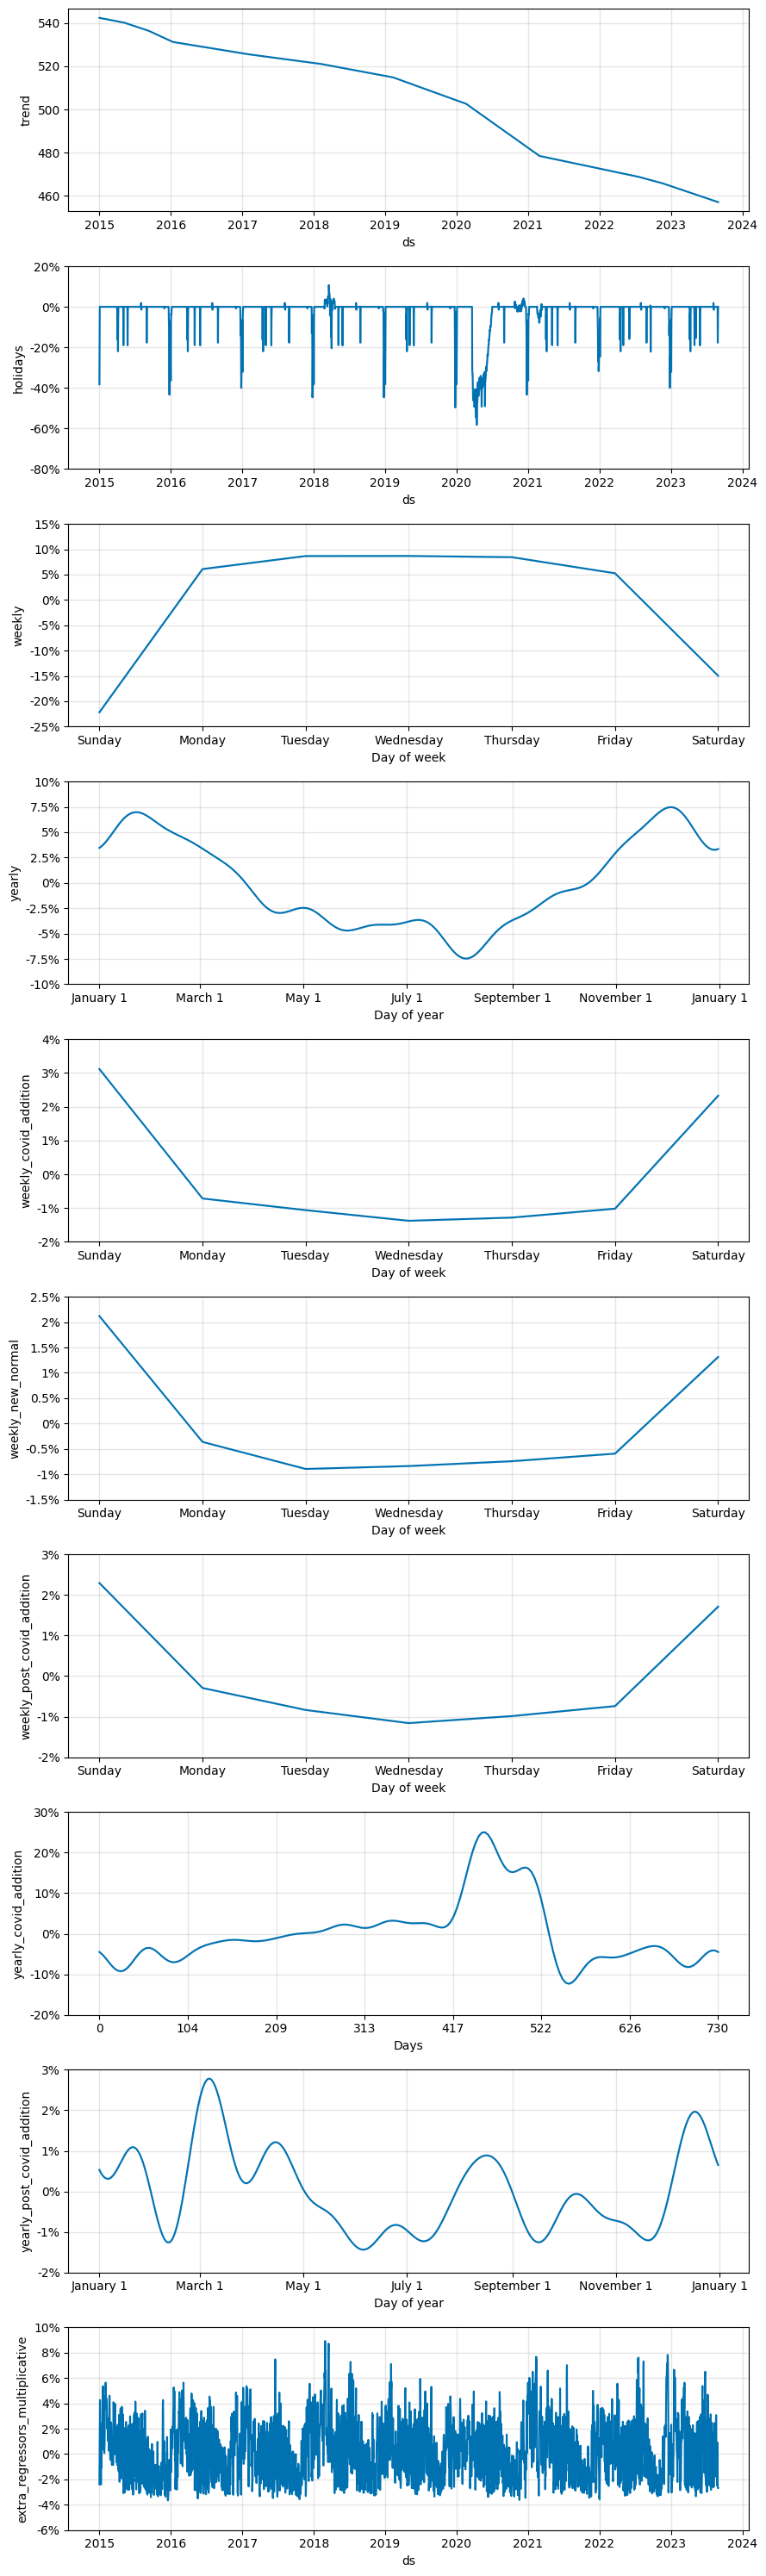

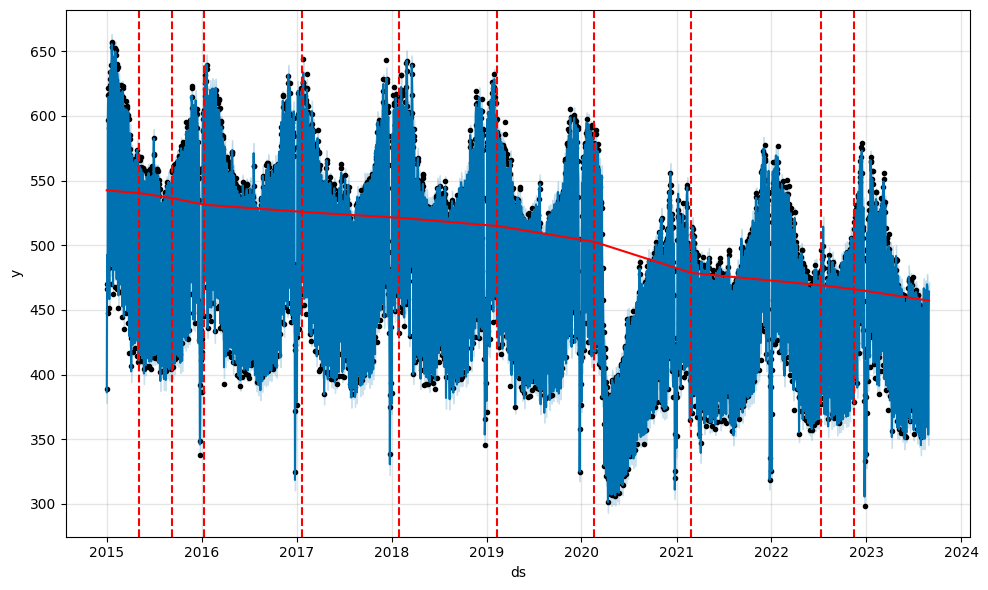

In [49]:
# Plotting the model's components and forecast including Backcast
best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
forecast = best_model.predict(future_df)
fig = best_model.plot_components(forecast)
plt.show()
fig = best_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, forecast)
plt.show()

## Prophet() Formulas, components, etc. understanding

### Looking into the components within the Prophet Python Object

In [50]:
### Parameters of the best model (Look for definitions in PPT)
# lp >> Log posterior density of the model parameters.
# k >> Growth rate parameter (slope).
# m >> initial intercept.
# delta [preprocess S size] >> slope change at each changepoint.
# sigma_obs >> standard deviation of the observations.
# beta [preprocess K size] >> coefficients for seasonality, holidats, regressors.
# trend [preprocess T size] >> estimated trend at each datetime.

best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
best_model.granularity = granularity[0]
forecast = best_model.predict(future_df)
print([x for x in best_model.params])
[best_model.params[x].size for x in best_model.params]

['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']


[1, 1, 1, 25, 1, 433, 3134]

In [51]:
# Default forecast DataFrame
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,beast_of_the_east,beast_of_the_east_lower,beast_of_the_east_upper,cdd,cdd_lower,cdd_upper,christmas_day_observed,christmas_day_observed_lower,christmas_day_observed_upper,coronation_of_charles_iii,coronation_of_charles_iii_lower,coronation_of_charles_iii_upper,easter_monday_england_wales_northern_ireland,easter_monday_england_wales_northern_ireland_lower,easter_monday_england_wales_northern_ireland_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,good_friday,good_friday_lower,good_friday_upper,hdd,hdd_lower,hdd_upper,holidays,holidays_lower,holidays_upper,late_summer_bank_holiday_england_wales_northern_ireland,late_summer_bank_holiday_england_wales_northern_ireland_lower,late_summer_bank_holiday_england_wales_northern_ireland_upper,lockdown_1,lockdown_1_lower,lockdown_1_upper,lockdown_2,lockdown_2_lower,lockdown_2_upper,lockdown_3,lockdown_3_lower,lockdown_3_upper,may_day,may_day_lower,may_day_upper,multiplicative_terms,multiplicative_terms_lower,...,xmas_ny_12_31_dow5_upper,xmas_ny_12_31_dow6,xmas_ny_12_31_dow6_lower,xmas_ny_12_31_dow6_upper,xmas_ny_12_31_dow7,xmas_ny_12_31_dow7_lower,xmas_ny_12_31_dow7_upper,xmas_ny_1_1_dow12,xmas_ny_1_1_dow12_lower,xmas_ny_1_1_dow12_upper,xmas_ny_1_1_dow34,xmas_ny_1_1_dow34_lower,xmas_ny_1_1_dow34_upper,xmas_ny_1_1_dow5,xmas_ny_1_1_dow5_lower,xmas_ny_1_1_dow5_upper,xmas_ny_1_1_dow6,xmas_ny_1_1_dow6_lower,xmas_ny_1_1_dow6_upper,xmas_ny_1_1_dow7,xmas_ny_1_1_dow7_lower,xmas_ny_1_1_dow7_upper,xmas_ny_1_2_dow12,xmas_ny_1_2_dow12_lower,xmas_ny_1_2_dow12_upper,xmas_ny_1_2_dow34,xmas_ny_1_2_dow34_lower,xmas_ny_1_2_dow34_upper,xmas_ny_1_2_dow5,xmas_ny_1_2_dow5_lower,xmas_ny_1_2_dow5_upper,xmas_ny_1_2_dow6,xmas_ny_1_2_dow6_lower,xmas_ny_1_2_dow6_upper,xmas_ny_1_2_dow7,xmas_ny_1_2_dow7_lower,xmas_ny_1_2_dow7_upper,yearly,yearly_lower,yearly_upper,yearly_covid_addition,yearly_covid_addition_lower,yearly_covid_addition_upper,yearly_post_covid_addition,yearly_post_covid_addition_lower,yearly_post_covid_addition_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01,542.426835,378.440500,394.791297,542.426835,542.426835,0.0,0.0,0.0,-0.00095,-0.00095,-0.00095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.023904,-0.023904,-0.023904,0.0,0.0,0.0,-0.013125,-0.013125,-0.013125,-0.382368,-0.382368,-0.382368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.287823,-0.287823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.382368,-0.382368,-0.382368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.034086,0.034086,0.034086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,386.303893
1,2015-01-02,542.409557,462.200219,477.932275,542.409557,542.409557,0.0,0.0,0.0,-0.00095,-0.00095,-0.00095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000567,0.000567,0.000567,0.0,0.0,0.0,0.025706,0.025706,0.025706,-0.221465,-0.221465,-0.221465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.133071,-0.133071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.221465,-0.221465,-0.221465,0.0,0.0,0.0,0.0,0.0,0.0,0.035176,0.035176,0.035176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,470.230570
2,2015-01-03,542.392279,484.430087,500.437597,542.392279,542.392279,0.0,0.0,0.0,-0.00095,-0.00095,-0.00095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021202,0.021202,0.021202,0.0,0.0,0.0,0.057329,0.057329,0.057329,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.091908,-0.091908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.036544,0.036544,0.036544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,492.542014
3,2015-01-04,542.375001,458.206208,474.196105,542.375001,542.375001,0.0,0.0,0.0,-0.00095,-0.00095,-0.00095,0.

In [52]:
# 1 for each coefficient
# There are 3 columns grouping holidays, regressors and all terms: holidays, extra_regressors_multiplicative, multiplicative_terms.
# Dropping them, the sum of 1s if beta [preprocess K size]

components = model.train_component_cols
print(components.drop(columns=['holidays', 'extra_regressors_multiplicative', 'multiplicative_terms']).sum().sum())
components.drop(columns=['holidays', 'extra_regressors_multiplicative', 'multiplicative_terms']).T.sum(axis=1)

433


component
beast_of_the_east                               55
cdd                                              1
christmas_day_observed                           3
coronation_of_charles_iii                        3
easter_monday_england_wales_northern_ireland     3
                                                ..
xmas_ny_1_2_dow7                                 1
yearly                                          20
yearly_covid_addition                           30
yearly_post_covid_addition                      20
additive_terms                                   0
Length: 90, dtype: int64

In [53]:
# Coefficients and values of the extra_regressors
regressor_coefficients(best_model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temperature,multiplicative,10.551490,0.004743,0.004743,0.004743
1,hdd,multiplicative,1191.209680,0.000034,0.000034,0.000034
2,cdd,multiplicative,46.788950,0.000020,0.000020,0.000020
3,sat_reg,multiplicative,-2461.160909,-0.000001,-0.000001,-0.000001
4,sun_reg,multiplicative,-2462.458013,-0.000002,-0.000002,-0.000002


In [54]:
# Example of the normal distribution of the extra_regressor "temperature"
print(best_model.extra_regressors['temperature'])

{'prior_scale': 25.341385191007195, 'standardize': 'auto', 'mu': 10.551489714313586, 'std': 4.924583311691614, 'mode': 'multiplicative'}


In [55]:
# All the extra_regressors' parameters
best_model.extra_regressors

OrderedDict([('temperature',
              {'prior_scale': 25.341385191007195,
               'standardize': 'auto',
               'mu': 10.551489714313586,
               'std': 4.924583311691614,
               'mode': 'multiplicative'}),
             ('hdd',
              {'prior_scale': 7.844906679590178,
               'standardize': 'auto',
               'mu': 1191.2096798120165,
               'std': 1215.0307111777581,
               'mode': 'multiplicative'}),
             ('cdd',
              {'prior_scale': 17.104622645962277,
               'standardize': 'auto',
               'mu': 46.78895007088999,
               'std': 167.2485403739787,
               'mode': 'multiplicative'}),
             ('sat_reg',
              {'prior_scale': 21.293559993722347,
               'standardize': 'auto',
               'mu': -2461.1609085079767,
               'std': 7426.119005411078,
               'mode': 'multiplicative'}),
             ('sun_reg',
              {'prior_scale

In [56]:
# Looking at the Inputs we give the model after they've been preprocessed (scaling, etc)
[
  'K', # number of variables' coefficients [BETA size in model.params].
  'S', # number of slope changes (at each changepoint) [DELTA size in model.params].
  'T', # number of estimated values of the trend component of the time series at each time point. [TREND size in model.params].
  'X', # Dataframe of TxK (each time series point and the variables coefficients as columns).
  'cap', # for logistic growth.
  's_a', # additive terms.
  's_m', # multiplicative terms.
  'sigmas', # Coefficients' prior_scales (Hyperparameters)
  't', # time.
  't_change', # value of t at changepoints.
  'tau', # changepoint prior_scale >> flexibility.
  'trend_indicator',
  'y' # standardized y values.
  ]
preprocess = best_model.preprocess(df)
preprocess

ModelInputData(T=3134, S=25, K=433, tau=0.022959961428617358, trend_indicator=0, y=0       0.591589
1       0.715743
2       0.709627
3       0.681695
4       0.908545
          ...   
3129    0.690209
3130    0.666601
3131    0.569242
3132    0.535946
3133    0.660355
Name: y_scaled, Length: 3134, dtype: float64, t=0       0.000000
1       0.000319
2       0.000638
3       0.000958
4       0.001277
          ...   
3129    0.998723
3130    0.999042
3131    0.999362
3132    0.999681
3133    1.000000
Name: t, Length: 3134, dtype: float64, cap=array([0., 0., 0., ..., 0., 0., 0.]), t_change=array([0.03989786, 0.07979572, 0.11969358, 0.15959145, 0.19948931,
       0.23938717, 0.27928503, 0.31918289, 0.35908075, 0.39897861,
       0.43887648, 0.47877434, 0.51835302, 0.55825088, 0.59814874,
       0.6380466 , 0.67794446, 0.71784232, 0.75774019, 0.79763805,
       0.83753591, 0.87743377, 0.91733163, 0.95722949, 0.99712735]), s_a=col
0      0
1      0
2      0
3      0
4      0
      ..
428   

In [57]:
# How the model parameters will be initialized under the number of regressors we are utilising:
print(best_model.calculate_initial_params(num_total_regressors=preprocess.K))

ModelParams(k=0.06876565678279867, m=0.5915892149405545, delta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), beta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [58]:
## Saving model:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(best_model))  # Save model

In [59]:
## Reading model:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

## Post-processing, graphs showing results

In [60]:
# Checking what are the input parameters and priors of the best model:
utils.hyper_params_df(trials)

,cdd,changepoint_prior_scale,changepoint_range,hdd,holidays_prior_scale,sat_reg,seasonality_prior_scale,sun_reg,temperature,cross_val_mape,cutoff_points,horizon_days,hopt_algorithm,max_iters,random_state,model_sector,model_granularity,model_mape,model_mdape,training_datetime
0,17.104623,0.02296,0.997156,7.844907,24.19641,21.29356,27.098166,20.502975,25.341385,0.146611,4,366,hyperopt.tpe,1,Generator(PCG64),Non-domestic,Daily,0.146611,0.121962,2024-10-10 12:56:25.635288


In [61]:
# Getting well formatted forecasts, etc.
best_model.forecast = forecast
best_model.full_forecast = utils.full_forecast_df(best_model, future=future_df, forecast=best_model.forecast)
best_model.reduced_forecast = utils.reduced_forecast_df(best_model, best_model.full_forecast)

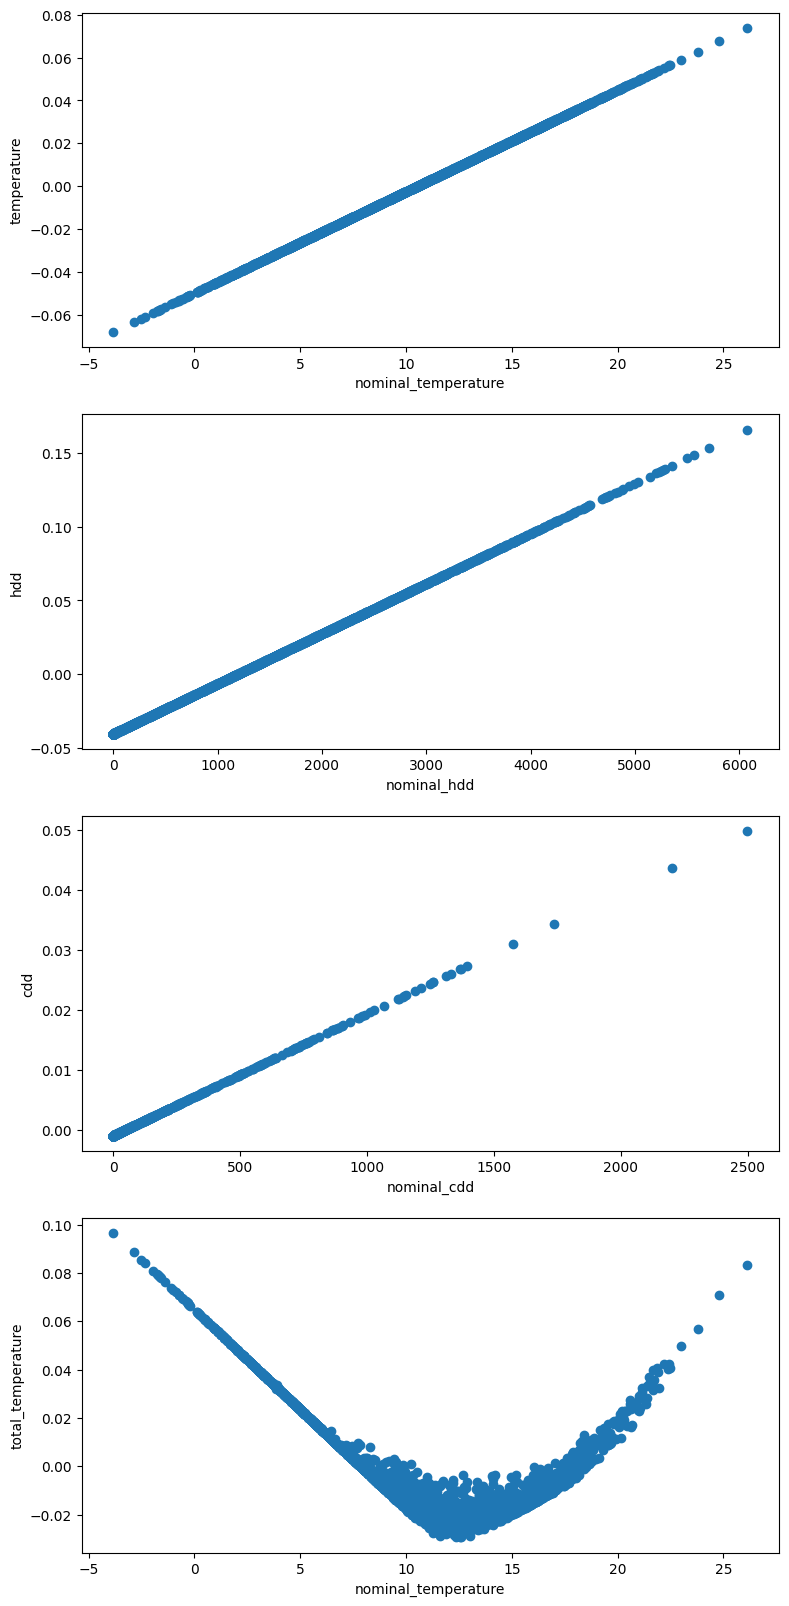

In [62]:
# Plotting Weather Regressors
fig = utils.plot_regressors_linearity(best_model)

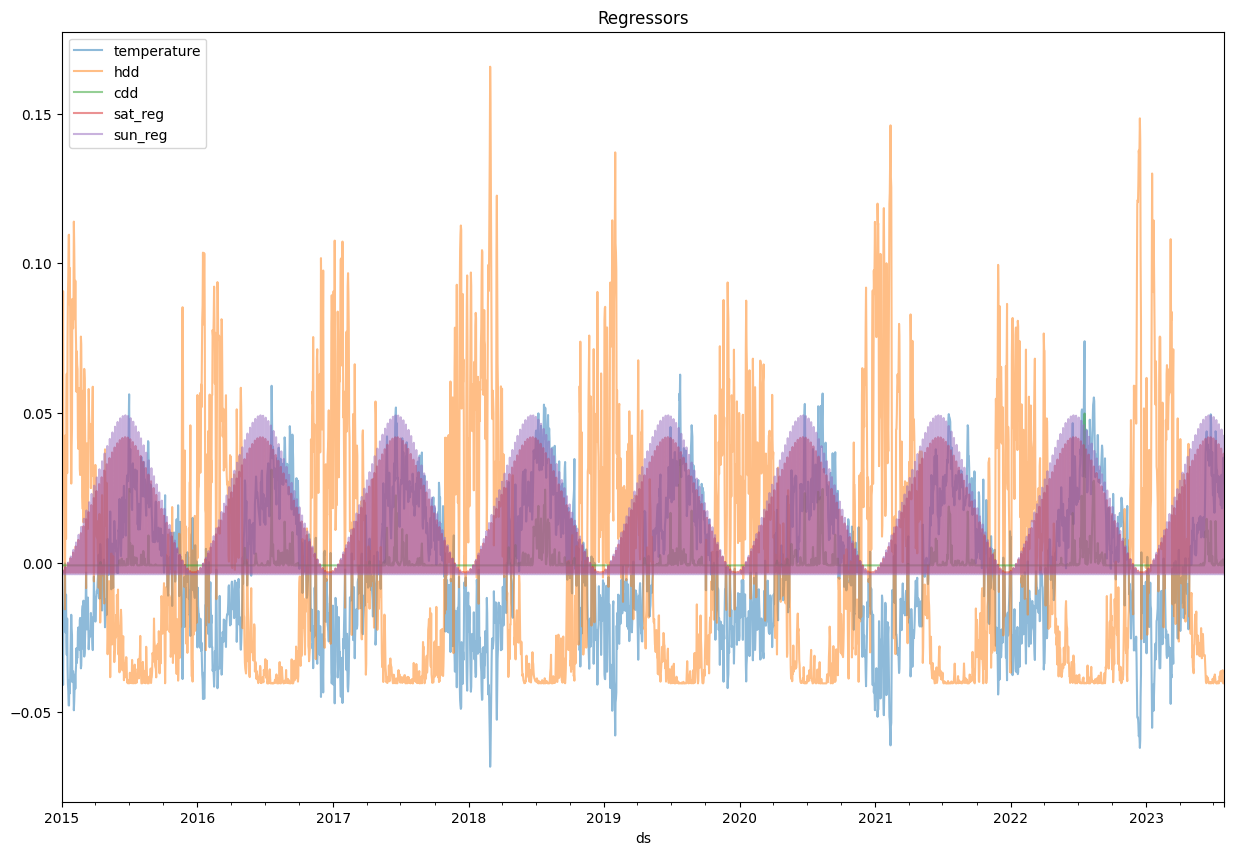

In [63]:
# Plotting Regressors' weights throughout time
fig2 = utils.plot_regressors(best_model)

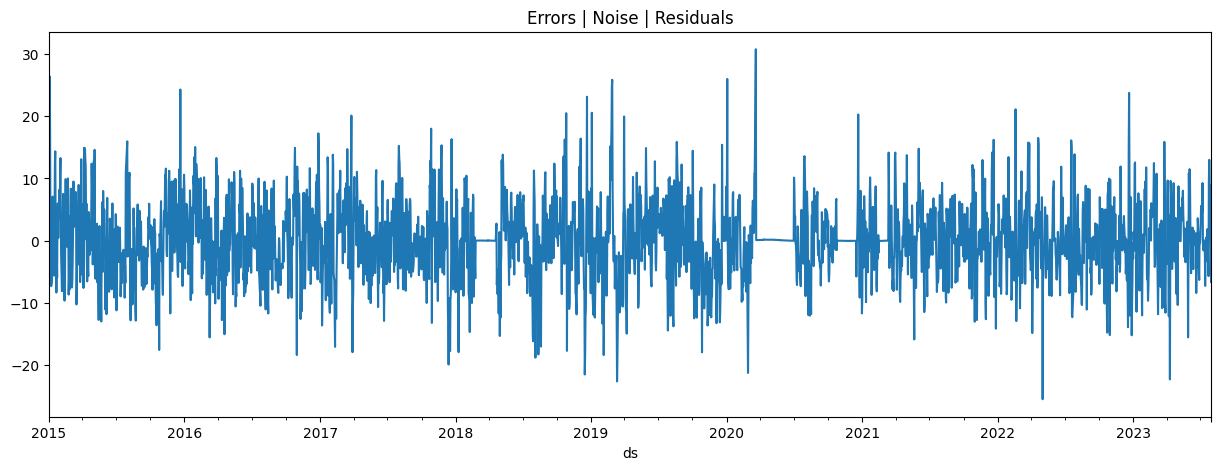

In [64]:
# Plotting Model's Noise / Errors
fig3 = utils.plot_noise_ts(best_model)

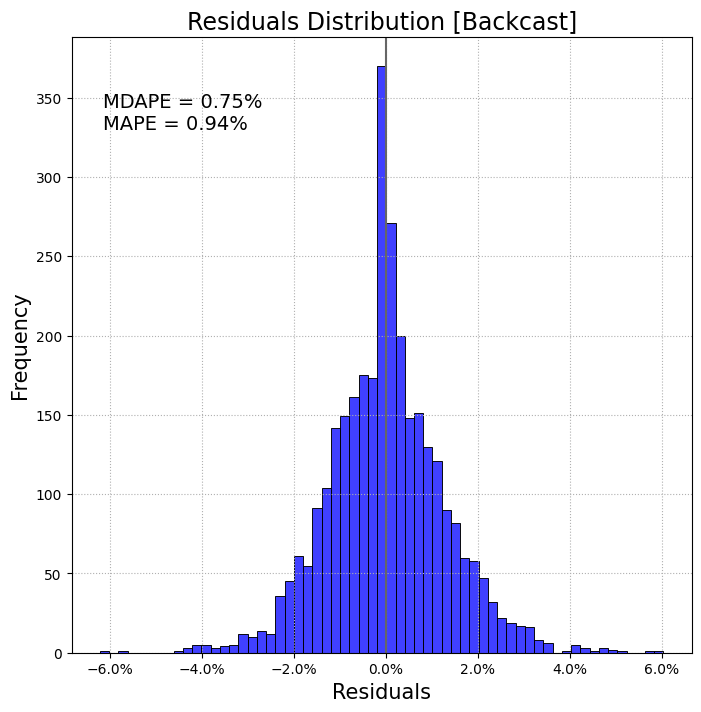

In [65]:
# Histogram of Model's Errors
fig4 = utils.plot_error_hist(best_model)

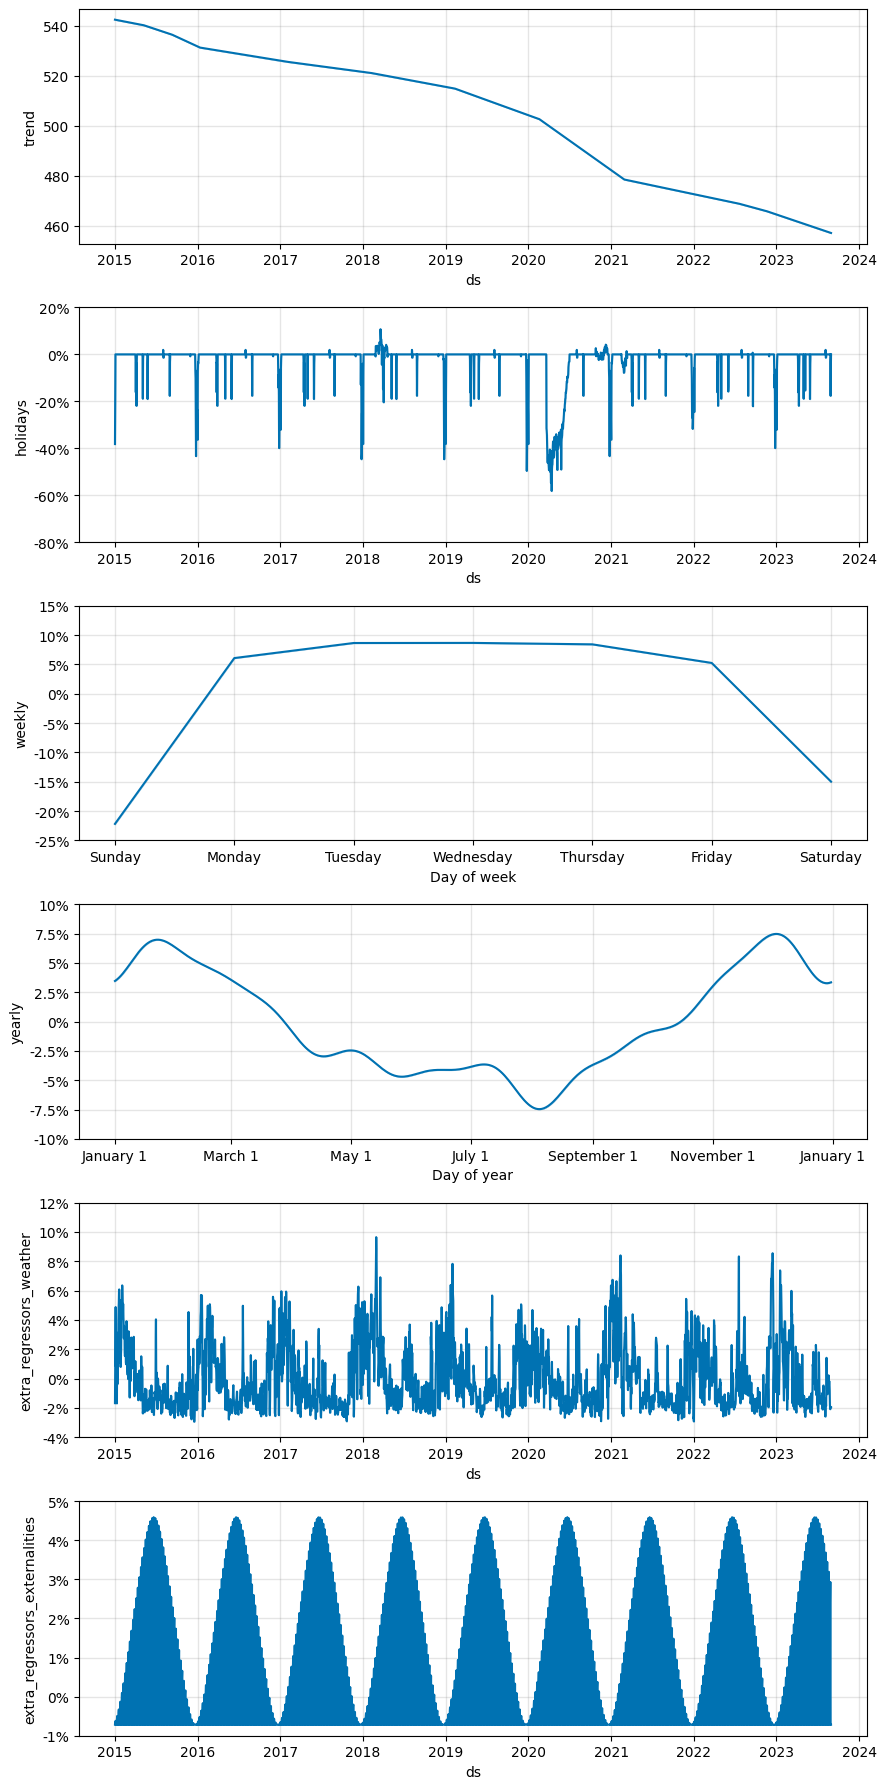

In [66]:
# Plotting components Tidely 
fig5 = utils.plot_base_components(best_model)

In [67]:
best_model.reduced_forecast.to_parquet(os.path.join(utils.outputs_folder, 'daily',f"{category}_{granularity}_reduced_forecast.parquet"))
best_model.full_forecast.to_parquet(os.path.join(utils.outputs_folder, 'daily',f"{category}_{granularity}_full_forecast.parquet"))

### Extras to show how to improve models

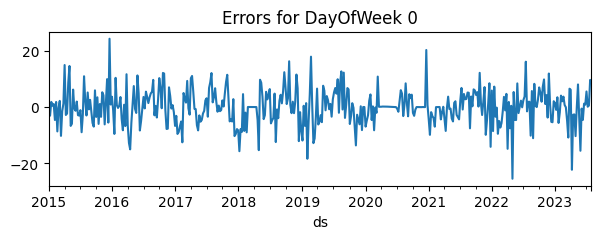

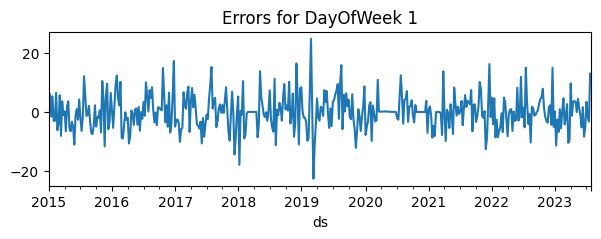

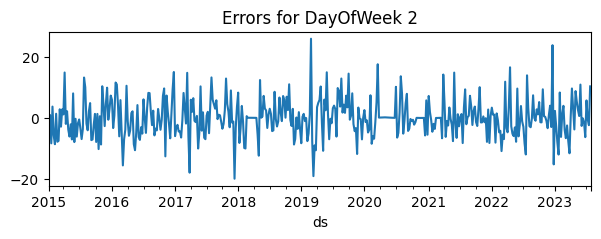

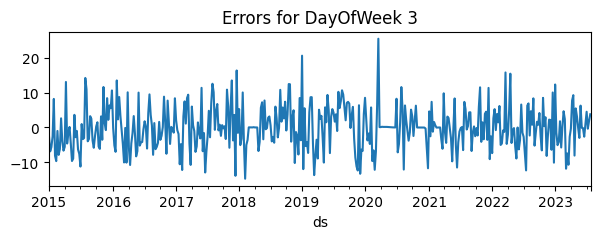

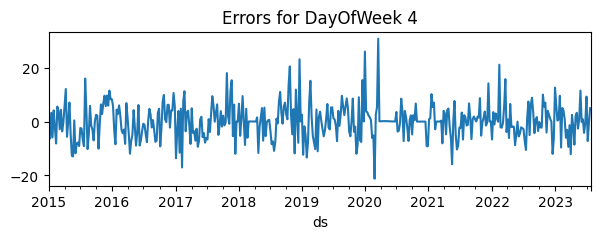

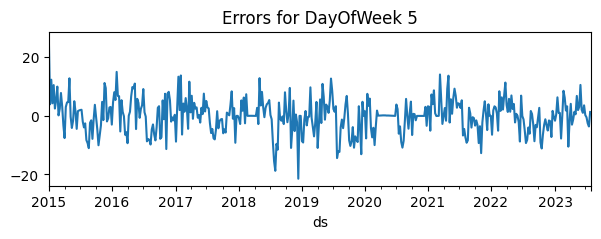

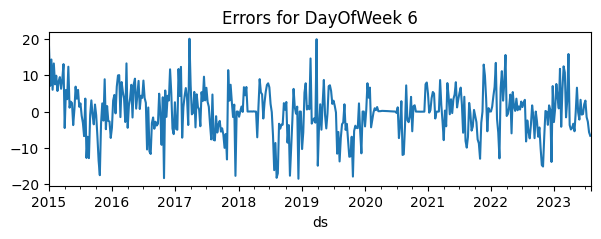

In [68]:
# Exploring noise by DOW:
# There is clearly more signals that can be retrieved from the model.

for dow in range(7):

  error_ax = best_model.full_forecast[(best_model.full_forecast['ds'] >= '2015-01-01') & (best_model.full_forecast['ds'].dt.day_of_week == dow)].dropna().set_index('ds')['residual'].plot(figsize=(
      7, 2), title=f'Errors for DayOfWeek {dow}', xlim=([best_model.history['ds'].min(), best_model.history['ds'].max()]))
  error_fig = error_ax.get_figure()
  plt.show()


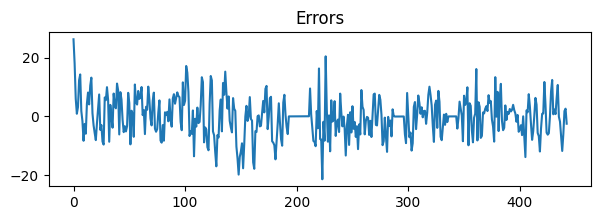

In [69]:
# Exploring noise of Temperature < 5 degrees:
# We should keep exploring (Actually creating functions to understand what "sub-timeseries" are less stationary)

error_ax = best_model.full_forecast[(best_model.full_forecast['ds'] >= '2015-01-01') & (best_model.full_forecast['nominal_temperature'] < 5)].dropna().reset_index(drop=True)['residual'].plot(figsize=(
    7, 2), title='Errors')
error_fig = error_ax.get_figure()
plt.show()